In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Connect to database
engine = create_engine('postgresql://localhost/parpass')

# Load all data
members_df = pd.read_sql("""
    SELECT m.id as member_id, m.first_name, m.last_name, 
           pt.name as tier, hp.name as health_plan
    FROM members m
    JOIN health_plans hp ON m.health_plan_id = hp.id
    JOIN plan_tiers pt ON hp.plan_tier_id = pt.id
    WHERE m.status = 'active'
""", engine)

courses_df = pd.read_sql("""
    SELECT id as course_id, name, city, state, tier_required, holes
    FROM golf_courses WHERE is_active = true
""", engine)

utilization_df = pd.read_sql("""
    SELECT member_id, course_id, checked_in_at, holes_played
    FROM golf_utilization
""", engine)

print(f"Members: {len(members_df)}")
print(f"Courses: {len(courses_df)}")
print(f"Utilization records: {len(utilization_df)}")


Members: 9
Courses: 22
Utilization records: 30


In [2]:
# Create a member-course interaction matrix
# This is the foundation of collaborative filtering

# Count how many times each member played each course
interaction_matrix = utilization_df.groupby(['member_id', 'course_id']).size().reset_index(name='plays')

# Pivot to create a matrix: rows = members, columns = courses
member_course_matrix = interaction_matrix.pivot(
    index='member_id', 
    columns='course_id', 
    values='plays'
).fillna(0)

print("Member-Course Interaction Matrix:")
print(f"Shape: {member_course_matrix.shape} (members x courses)")
print(f"\nSample of the matrix:")
member_course_matrix.head()


Member-Course Interaction Matrix:
Shape: (9, 9) (members x courses)

Sample of the matrix:


course_id,11111111-aaaa-1111-aaaa-111111111111,22222222-bbbb-2222-bbbb-222222222222,33333333-cccc-3333-cccc-333333333333,44444444-dddd-4444-dddd-444444444444,55555555-eeee-5555-eeee-555555555555,66666666-ffff-6666-ffff-666666666666,77777777-aaaa-7777-aaaa-777777777777,88888888-bbbb-8888-bbbb-888888888888,99999999-cccc-9999-cccc-999999999999
member_id,,,,,,,,,
aaaaaaaa-0001-0001-0001-000000000001,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
aaaaaaaa-0002-0002-0002-000000000002,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
aaaaaaaa-0003-0003-0003-000000000003,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
aaaaaaaa-0004-0004-0004-000000000004,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
aaaaaaaa-0005-0005-0005-000000000005,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,2.0


In [3]:
# Calculate member similarity using cosine similarity
# This finds members with similar playing patterns

from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarity between all members
member_similarity = cosine_similarity(member_course_matrix)
member_similarity_df = pd.DataFrame(
    member_similarity,
    index=member_course_matrix.index,
    columns=member_course_matrix.index
)

print("Member Similarity Matrix:")
print("(1.0 = identical patterns, 0.0 = completely different)\n")

# Make it readable with names
member_names = members_df.set_index('member_id')['first_name'].to_dict()
readable_similarity = member_similarity_df.copy()
readable_similarity.index = [member_names.get(m, m)[:10] for m in readable_similarity.index]
readable_similarity.columns = [member_names.get(m, m)[:10] for m in readable_similarity.columns]
readable_similarity.round(2)


Member Similarity Matrix:
(1.0 = identical patterns, 0.0 = completely different)



,Marcus,Rachel,Derek,Amanda,Carlos,Kevin,Stephanie,Michael,Jessica
Marcus,1.00,0.35,0.88,0.29,0.27,0.35,0.00,0.29,0.00
Rachel,0.35,1.00,0.50,0.41,0.19,0.50,0.71,0.00,0.71
Derek,0.88,0.50,1.00,0.20,0.19,0.75,0.00,0.20,0.00
Amanda,0.29,0.41,0.20,1.00,0.62,0.00,0.58,0.67,0.58
Carlos,0.27,0.19,0.19,0.62,1.00,0.00,0.27,0.77,0.27
Kevin,0.35,0.50,0.75,0.00,0.00,1.00,0.00,0.00,0.00
Stephanie,0.00,0.71,0.00,0.58,0.27,0.00,1.00,0.00,1.00
Michael,0.29,0.00,0.20,0.67,0.77,0.00,0.00,1.00,0.00
Jessica,0.00,0.71,0.00,0.58,0.27,0.00,1.00,0.00,1.00


In [4]:
def get_recommendations(member_id, n_recommendations=5):
    """
    Collaborative filtering recommendation engine
    
    How it works:
    1. Find members similar to the target member
    2. Look at courses those similar members played
    3. Recommend courses the target hasn't played yet
    4. Weight by similarity score
    """
    
    # Get member's tier to filter accessible courses
    member_tier = members_df[members_df['member_id'] == member_id]['tier'].values[0]
    is_premium = member_tier == 'premium'
    
    # Courses this member has already played
    played_courses = set(member_course_matrix.loc[member_id][member_course_matrix.loc[member_id] > 0].index)
    
    # Get similarity scores for this member
    similarities = member_similarity_df[member_id].drop(member_id)
    
    # Calculate weighted scores for each course
    course_scores = {}
    
    for course_id in member_course_matrix.columns:
        # Skip courses already played
        if course_id in played_courses:
            continue
            
        # Check tier access
        course_tier = courses_df[courses_df['course_id'] == course_id]['tier_required'].values[0]
        if course_tier == 'premium' and not is_premium:
            continue
        
        # Calculate score: sum of (similarity * plays) for all other members
        score = 0
        for other_member_id in similarities.index:
            similarity = similarities[other_member_id]
            plays = member_course_matrix.loc[other_member_id, course_id]
            score += similarity * plays
        
        course_scores[course_id] = score
    
    # Sort and get top N
    sorted_courses = sorted(course_scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    
    # Create results dataframe
    results = []
    for course_id, score in sorted_courses:
        course_info = courses_df[courses_df['course_id'] == course_id].iloc[0]
        
        # Find which similar members played this course
        similar_members_who_played = []
        for other_id in similarities.index:
            if member_course_matrix.loc[other_id, course_id] > 0 and similarities[other_id] > 0.3:
                other_name = member_names.get(other_id, 'Unknown')
                similar_members_who_played.append(other_name)
        
        results.append({
            'course_name': course_info['name'],
            'city': course_info['city'],
            'tier': course_info['tier_required'],
            'score': round(score, 2),
            'reason': f"Members like you played here: {', '.join(similar_members_who_played[:2])}" if similar_members_who_played else "Popular in your tier"
        })
    
    return pd.DataFrame(results)

# Test it - get recommendations for Marcus (PP100001)
marcus_id = 'aaaaaaaa-0001-0001-0001-000000000001'
print(f"Recommendations for Marcus (Premium member):\n")
get_recommendations(marcus_id)


Recommendations for Marcus (Premium member):



IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
def get_recommendations(member_id, n_recommendations=5):
    """
    Collaborative filtering recommendation engine
    
    How it works:
    1. Find members similar to the target member
    2. Look at courses those similar members played
    3. Recommend courses the target hasn't played yet
    4. Weight by similarity score
    """
    
    # Get member's tier to filter accessible courses
    member_tier = members_df[members_df['member_id'] == member_id]['tier'].values[0]
    is_premium = member_tier == 'premium'
    
    # Courses this member has already played
    played_courses = set(member_course_matrix.loc[member_id][member_course_matrix.loc[member_id] > 0].index)
    
    # Get similarity scores for this member
    similarities = member_similarity_df[member_id].drop(member_id)
    
    # Calculate weighted scores for each course
    course_scores = {}
    
    for course_id in member_course_matrix.columns:
        # Skip courses already played
        if course_id in played_courses:
            continue
            
        # Check tier access
        course_tier = courses_df[courses_df['course_id'] == course_id]['tier_required'].values[0]
        if course_tier == 'premium' and not is_premium:
            continue
        
        # Calculate score: sum of (similarity * plays) for all other members
        score = 0
        for other_member_id in similarities.index:
            similarity = similarities[other_member_id]
            plays = member_course_matrix.loc[other_member_id, course_id]
            score += similarity * plays
        
        course_scores[course_id] = score
    
    # Sort and get top N
    sorted_courses = sorted(course_scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    
    # Create results dataframe
    results = []
    for course_id, score in sorted_courses:
        course_info = courses_df[courses_df['course_id'] == course_id].iloc[0]
        
        # Find which similar members played this course
        similar_members_who_played = []
        for other_id in similarities.index:
            if member_course_matrix.loc[other_id, course_id] > 0 and similarities[other_id] > 0.3:
                other_name = member_names.get(other_id, 'Unknown')
                similar_members_who_played.append(other_name)
        
        results.append({
            'course_name': course_info['name'],
            'city': course_info['city'],
            'tier': course_info['tier_required'],
            'score': round(score, 2),
            'reason': f"Members like you played here: {', '.join(similar_members_who_played[:2])}" if similar_members_who_played else "Popular in your tier"
        })
    
    return pd.DataFrame(results)

# Test it - get recommendations for Marcus (PP100001)
marcus_id = 'aaaaaaaa-0001-0001-0001-000000000001'
print(f"Recommendations for Marcus (Premium member):\n")
get_recommendations(marcus_id)


Recommendations for Marcus (Premium member):



IndexError: index 0 is out of bounds for axis 0 with size 0

In [6]:
# Check actual member IDs
print("Member IDs in database:")
print(members_df[['member_id', 'first_name']].to_string())


Member IDs in database:
                              member_id first_name
0  aaaaaaaa-0001-0001-0001-000000000001     Marcus
1  aaaaaaaa-0002-0002-0002-000000000002     Rachel
2  aaaaaaaa-0003-0003-0003-000000000003      Derek
3  aaaaaaaa-0004-0004-0004-000000000004     Amanda
4  aaaaaaaa-0005-0005-0005-000000000005     Carlos
5  aaaaaaaa-0007-0007-0007-000000000007      Kevin
6  aaaaaaaa-0008-0008-0008-000000000008  Stephanie
7  aaaaaaaa-0009-0009-0009-000000000009    Michael
8  aaaaaaaa-0010-0010-0010-000000000010    Jessica


In [7]:
# Check who's in the interaction matrix
print("Members in interaction matrix:")
print(list(member_course_matrix.index))
print(f"\nMarcus ID: {marcus_id}")
print(f"Is Marcus in matrix? {marcus_id in member_course_matrix.index}")


Members in interaction matrix:
[UUID('aaaaaaaa-0001-0001-0001-000000000001'), UUID('aaaaaaaa-0002-0002-0002-000000000002'), UUID('aaaaaaaa-0003-0003-0003-000000000003'), UUID('aaaaaaaa-0004-0004-0004-000000000004'), UUID('aaaaaaaa-0005-0005-0005-000000000005'), UUID('aaaaaaaa-0007-0007-0007-000000000007'), UUID('aaaaaaaa-0008-0008-0008-000000000008'), UUID('aaaaaaaa-0009-0009-0009-000000000009'), UUID('aaaaaaaa-0010-0010-0010-000000000010')]

Marcus ID: aaaaaaaa-0001-0001-0001-000000000001
Is Marcus in matrix? False


In [8]:
# Convert matrix index to strings for easier comparison
member_course_matrix.index = member_course_matrix.index.astype(str)
member_similarity_df.index = member_similarity_df.index.astype(str)
member_similarity_df.columns = member_similarity_df.columns.astype(str)

# Also convert member_id column in members_df
members_df['member_id'] = members_df['member_id'].astype(str)

# Now test again
print(f"Is Marcus in matrix? {marcus_id in member_course_matrix.index}")
print(f"\nRecommendations for Marcus (Premium member):\n")
get_recommendations(marcus_id)


Is Marcus in matrix? True

Recommendations for Marcus (Premium member):



,course_name,city,tier,score,reason
0,Timuquana Country Club,Jacksonville,premium,1.24,"Members like you played here: Unknown, Unknown"
1,Jacksonville Beach Golf Club,Jacksonville Beach,core,0.91,Members like you played here: Unknown
2,Blue Sky Golf Club,Jacksonville,core,0.84,Popular in your tier
3,Bent Creek Golf Course,Jacksonville,core,0.82,Popular in your tier
4,Hidden Hills Golf Club,Jacksonville,core,0.53,Popular in your tier


In [9]:
# Fix member names dict to use string keys
member_names = {str(k): v for k, v in members_df.set_index('member_id')['first_name'].to_dict().items()}

# Update the function with the fix and test both member types
def get_recommendations(member_id, n_recommendations=5):
    """
    Collaborative filtering recommendation engine
    """
    member_id = str(member_id)  # Ensure string
    
    # Get member's tier
    member_tier = members_df[members_df['member_id'] == member_id]['tier'].values[0]
    is_premium = member_tier == 'premium'
    
    # Courses this member has already played
    played_courses = set(member_course_matrix.loc[member_id][member_course_matrix.loc[member_id] > 0].index)
    
    # Get similarity scores
    similarities = member_similarity_df[member_id].drop(member_id)
    
    # Calculate weighted scores for each course
    course_scores = {}
    
    for course_id in member_course_matrix.columns:
        if course_id in played_courses:
            continue
            
        course_tier = courses_df[courses_df['course_id'] == course_id]['tier_required'].values[0]
        if course_tier == 'premium' and not is_premium:
            continue
        
        score = 0
        for other_member_id in similarities.index:
            similarity = similarities[other_member_id]
            plays = member_course_matrix.loc[other_member_id, course_id]
            score += similarity * plays
        
        course_scores[course_id] = score
    
    sorted_courses = sorted(course_scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    
    results = []
    for course_id, score in sorted_courses:
        course_info = courses_df[courses_df['course_id'] == course_id].iloc[0]
        
        similar_members_who_played = []
        for other_id in similarities.index:
            if member_course_matrix.loc[other_id, course_id] > 0 and similarities[other_id] > 0.3:
                other_name = member_names.get(str(other_id), 'Unknown')
                similar_members_who_played.append(other_name)
        
        results.append({
            'course_name': course_info['name'],
            'city': course_info['city'],
            'tier': course_info['tier_required'],
            'score': round(score, 2),
            'reason': f"Played by: {', '.join(similar_members_who_played[:2])}" if similar_members_who_played else "Recommended for you"
        })
    
    return pd.DataFrame(results)

# Test for Marcus (Premium)
print("=== Marcus (Premium) ===")
print(get_recommendations('aaaaaaaa-0001-0001-0001-000000000001'))

print("\n=== Amanda (Core) ===")
amanda_id = 'aaaaaaaa-0004-0004-0004-000000000004'
print(get_recommendations(amanda_id))


=== Marcus (Premium) ===
                    course_name                city     tier  score  \
0        Timuquana Country Club        Jacksonville  premium   1.24   
1  Jacksonville Beach Golf Club  Jacksonville Beach     core   0.91   
2            Blue Sky Golf Club        Jacksonville     core   0.84   
3        Bent Creek Golf Course        Jacksonville     core   0.82   
4        Hidden Hills Golf Club        Jacksonville     core   0.53   

                    reason  
0  Played by: Derek, Kevin  
1        Played by: Rachel  
2      Recommended for you  
3      Recommended for you  
4      Recommended for you  

=== Amanda (Core) ===
              course_name          city  tier  score  \
0  Bent Creek Golf Course  Jacksonville  core   1.90   
1  Hidden Hills Golf Club  Jacksonville  core   1.23   

                       reason  
0  Played by: Carlos, Michael  
1           Played by: Carlos  


In [10]:
import pickle

# Save the model components
model_data = {
    'member_course_matrix': member_course_matrix,
    'member_similarity_df': member_similarity_df,
    'members_df': members_df,
    'courses_df': courses_df,
    'member_names': member_names
}

with open('recommendation_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved to recommendation_model.pkl")
print(f"File size: {round(os.path.getsize('recommendation_model.pkl') / 1024, 2)} KB")


Model saved to recommendation_model.pkl


NameError: name 'os' is not defined

In [10]:
import pickle

# Save the model components
model_data = {
    'member_course_matrix': member_course_matrix,
    'member_similarity_df': member_similarity_df,
    'members_df': members_df,
    'courses_df': courses_df,
    'member_names': member_names
}

with open('recommendation_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved to recommendation_model.pkl")
print(f"File size: {round(os.path.getsize('recommendation_model.pkl') / 1024, 2)} KB")


Model saved to recommendation_model.pkl


NameError: name 'os' is not defined

In [11]:
import os
print(f"Model saved! File size: {round(os.path.getsize('recommendation_model.pkl') / 1024, 2)} KB")


Model saved! File size: 7.98 KB


In [12]:
import pickle

# Save the model components
model_data = {
    'member_course_matrix': member_course_matrix,
    'member_similarity_df': member_similarity_df,
    'members_df': members_df,
    'courses_df': courses_df,
    'member_names': member_names
}

with open('recommendation_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved to recommendation_model.pkl")
print(f"File size: {round(os.path.getsize('recommendation_model.pkl') / 1024, 2)} KB")


Model saved to recommendation_model.pkl
File size: 7.98 KB


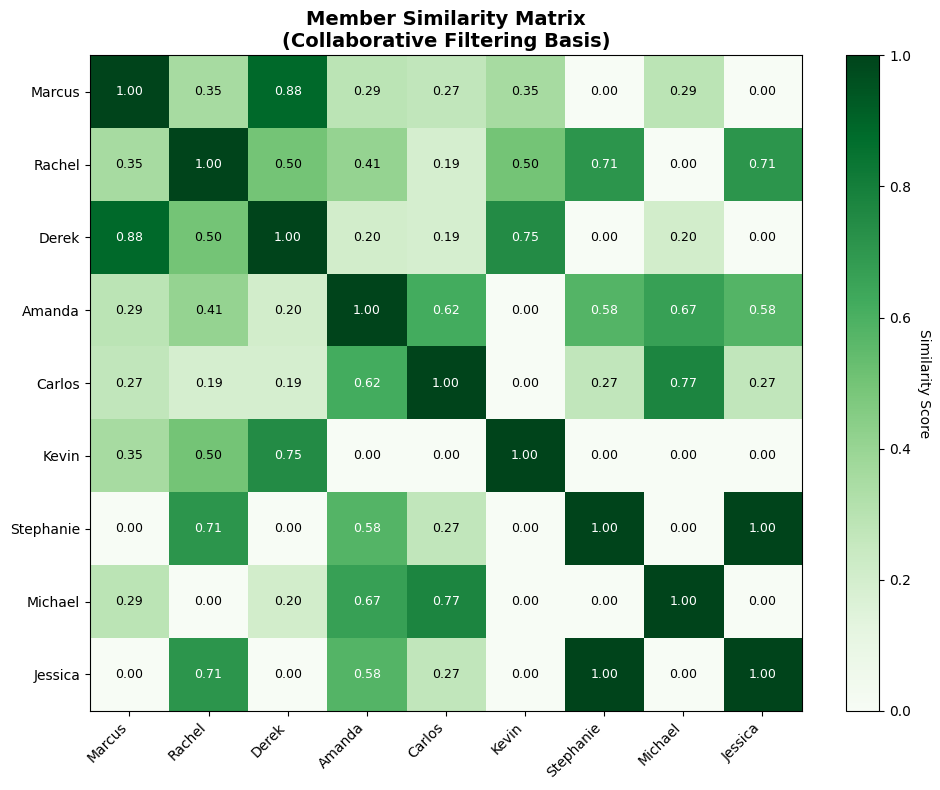


Heatmap saved to member_similarity_heatmap.png


In [13]:
import matplotlib.pyplot as plt

# Create a heatmap of member similarities
fig, ax = plt.subplots(figsize=(10, 8))

# Use the readable names
similarity_display = member_similarity_df.copy()
similarity_display.index = [member_names.get(m, m)[:10] for m in similarity_display.index]
similarity_display.columns = [member_names.get(m, m)[:10] for m in similarity_display.columns]

im = ax.imshow(similarity_display.values, cmap='Greens', aspect='auto', vmin=0, vmax=1)

# Add labels
ax.set_xticks(range(len(similarity_display.columns)))
ax.set_yticks(range(len(similarity_display.index)))
ax.set_xticklabels(similarity_display.columns, rotation=45, ha='right')
ax.set_yticklabels(similarity_display.index)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Similarity Score', rotation=-90, va='bottom')

# Add values in cells
for i in range(len(similarity_display.index)):
    for j in range(len(similarity_display.columns)):
        val = similarity_display.iloc[i, j]
        color = 'white' if val > 0.5 else 'black'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=color, fontsize=9)

ax.set_title('Member Similarity Matrix\n(Collaborative Filtering Basis)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('member_similarity_heatmap.png', dpi=150)
plt.show()

print("\nHeatmap saved to member_similarity_heatmap.png")
